In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import progressbar as P
from helper import getLLPs,getModelDict,splitModels
from ATLAS_data.effFunctions import (getMuonRecoEff,getTriggerEff,getTrackEff,
                                     getSelectionEff,getTargetMass,getMassSelEff,
                                     massLong,massShort)
from atlas_susy_2018_42_Recast import getHSCPCandidates,applyHSCPSelection,applyIsolation,applyMuonTagging,removeFromMET,applyMTCut

delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

Welcome to JupyROOT 6.24/06


In [2]:
inputFile = '../eventData/pp2Gluino_atlas_scan/Events/run_02/gluino_400_370.0_tau_3e+01_delphes_events.root'
# inputFile = '../eventData/pp2BB1j_atlas_scan_hscp/Events/run_05/cdfo_105_100.0_tau_6e+00_delphes_events.root'

In [3]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
ntotal = 0
nLLPs = []
nCharged = []
for ievt in range(nevts):    
    
    ntotal += 1
    tree.GetEntry(ievt)   
    weightPB = tree.Weight.At(1).Weight

    metCalo = tree.MissingETCalo.At(0).MET
    llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters,tree.bsmMothers)
    # if len(llps) == 0:
        # break
    nLLPs.append(len(llps))
    hscpCandidates = getHSCPCandidates(llps)
    nCharged.append(len(hscpCandidates))
    # hscpCandidates = getHSCPCandidates(tree.isoRhadrons,tree.rhadronDaughters,llps)
    # break
f.Close()

Error getting charge for 1000021


TypeError: bad operand type for abs(): 'NoneType'

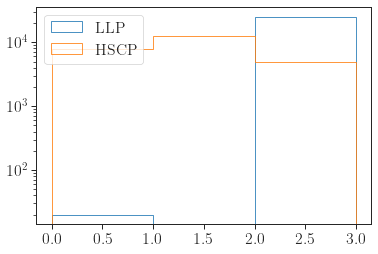

In [9]:
ht,_,_ = plt.hist(nLLPs,bins=np.arange(0.,4.,1.),label='LLP',histtype='step')
h,_,_ = plt.hist(nCharged,bins=np.arange(0.,4.,1.),label='HSCP',histtype='step')
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

In [10]:
ht

array([2.0000e+01, 0.0000e+00, 2.4976e+04])

In [6]:
h

array([167., 257.,  99.])

In [4]:
print('BSM:')
for p in tree.bsm:
    print(p.PID,p.Mass,p.Status,p.Charge)

print('\nMothers:')
for p in tree.bsmMothers:
    print(p.PID,p.Mass,p.Status,p.Charge)

print('\nDirect Daughters:')
for p in tree.bsmDirectDaughters:
    print(p.PID,p.Mass,p.Status,p.Charge)        

print('\nFinal Daughters:')    
for p in tree.bsmFinalDaughters:
    print(p.PID,p.Mass,p.Status,p.Charge)        



print('\n\n LLPs:')    
for p in llps:
    print(p.PID,p.Mass,p.Status,p.Charge)   

BSM:
1000021 400.0 102 0
1000021 400.0 102 0

Mothers:
1000021 400.0 101 0
1000021 400.0 101 0

Direct Daughters:
-1009002 400.5556945800781 103 -999
1009002 400.5556945800781 103 -999

Final Daughters:
1009223 401.04998779296875 1 -999
-2112 0.9395700097084045 1 0
2112 0.9395700097084045 1 0
-211 0.13956999778747559 1 -1
-211 0.13956999778747559 1 -1
130 0.4976100027561188 1 0
211 0.13956999778747559 1 1
-211 0.13956999778747559 1 -1
211 0.13956999778747559 1 1
130 0.4976100027561188 1 0
22 0.0 1 0
11 0.0005109999910928309 1 -1
-11 0.0005109999910928309 1 1
1009223 400.9932556152344 1 -999


1000021 400.0 101 0
1000021 400.0 101 0


In [9]:
candidates = []    
for ip in range(tree.rhadron.GetEntries()):
    rhadron = tree.rhadron.At(ip)
    print('R-hadron:',rhadron.PID)
    # if abs(rhadron.Charge) == 1: # Skip neutral or multicharged particles
        # continue
    
    # Map rhadron to llp (parton)
    # (check which llp came from the R-hadron)
    rhadron_ddaughters = []
    for jp in range(tree.rhadronDaughters.GetEntries()):
        d = tree.rhadronDaughters.At(jp)
        print('  dE=',d.E)
        for llp in llps:
            print(llp.PID,llp.E,llp is d)
        if d.M1 == ip:
            rhadron_ddaughters.append(d)
    print([(d.PID,d.Charge) for d in rhadron_ddaughters])
    totalCharge = sum([d.Charge for d in rhadron_ddaughters])
    x = rhadron_ddaughters[0].X
    totalE = sum([d.E for d in rhadron_ddaughters])
    print('  Charge=',totalCharge,'X=',x,'totalE = ',totalE,rhadron.E)


R-hadron: 1009113


AttributeError: 'TTree' object has no attribute 'rhadronDaughters'

In [21]:
tree.bsmMothers.GetEntries()

0

In [8]:
candidates

[]

In [8]:
for p in tree.isoLLPs:
    # p = tree.bsmFinalDaughters.At(ip)
    print(p.PID,p.Mass,p.Status,p.Charge)

AttributeError: 'TTree' object has no attribute 'isoLLPs'

In [38]:
for ip in range(tree.Particle.GetEntries()):
    p = tree.Particle.At(ip)
    if abs(p.PID) < 10000:
        continue
    if p.Charge == 0:
        continue
    print(p.PID,p.Status,p.Charge,p.Mass)

2212 4 1 0.9382699728012085
2203 63 1 0.7713299989700317
2212 4 1 0.9382699728012085
-1009002 103 -999 400.70001220703125
-1009002 102 -999 400.70001220703125
1009323 104 -999 401.2250061035156
1009002 103 -999 400.5249938964844
1009002 102 -999 400.5249938964844
1009223 104 -999 401.04998779296875
2203 72 1 0.7713299989700317
213 2 1 0.7540422677993774
-211 1 -1 0.13956999778747559
211 1 1 0.13956999778747559
-213 2 -1 0.754854679107666
211 1 1 0.13956999778747559
-213 2 -1 0.7838952541351318
211 1 1 0.13956999778747559
-211 1 -1 0.13956999778747559
213 2 1 1.2140008211135864
-213 2 -1 0.6929205060005188
2212 1 1 0.9382699728012085
-211 1 -1 0.13956999778747559
321 1 1 0.4936800003051758
-211 1 -1 0.13956999778747559
211 1 1 0.13956999778747559
-321 1 -1 0.4936800003051758
211 1 1 0.13956999778747559
211 1 1 0.13956999778747559
-211 1 -1 0.13956999778747559
213 2 1 0.8911933302879333
-211 1 -1 0.13956999778747559
211 1 1 0.13956999778747559
-211 1 -1 0.13956999778747559
321 1 1 0.4936

In [24]:
class Bla(object):

    def __init__(self,x) -> None:
        self.x = None
        self.done = False
        if x != 0:
            self.x = x
        else:
            return
        self.done = True

In [26]:
b = Bla(1)
print(b.x,b.done)

1 True
